In [ ]:
from pathlib import Path
import torch
import torchmetrics
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import random
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score
from sklearn import metrics

In [72]:
labels_tra = pd.read_csv("D:\AI2\Chest-Xraytra.csv")
labels_val = pd.read_csv("D:\AI2\Chest-Xrayval.csv")

In [73]:
labels_tra.head(10)

patientId  SurgeryDate  EF  EF<40  EF<50  MR0  MR1  MS0  MS1  AS0  AS1  \
0    1071954          NaN  25      1      1    1    1    0    0    0    0   
1    1291521          NaN  55      0      0    1    1    0    0    0    0   
2    1721359          NaN  50      0      0    1    0    0    0    0    0   
3    1175180          NaN  55      0      0    0    0    0    0    0    0   
4     843616          NaN  55      0      0    1    0    0    0    0    0   
5     424405          NaN  40      0      1    0    0    0    0    0    0   
6    1141108          NaN  45      0      1    1    0    0    0    0    0   
7    1202367          NaN  45      0      1    0    0    0    0    0    0   
8    1278106          NaN  40      0      1    1    0    0    0    0    0   
9    1317915          NaN  50      0      0    0    0    0    0    0    0   

   AR0   AR1  TR0  TR1  PR0  PR1  
0     0    0    1    0    1    0  
1     0    0    0    0    0    0  
2     0    0    1    1    1    0  
3     0    0    0    0    1    0  
4     0    0    0    0    1    0  
5     0    0    0    0    0    0  
6     0    0    1    0    0    0  
7     0    0    0    0    1    0  
8     0    0    1    0    1    0  
9     1    0    1    0    1    0

In [74]:
train_PATH = Path("D:/AI2/Dataset/Train/")
val_PATH = Path("D:/AI2/Dataset/Val/")

In [5]:
dcm = pydicom.read_file('D:\AI2\Dataset\Train/1202367.dcm').pixel_array
#dcm = dcm/ dcm.max()
dcm=np.expand_dims(dcm, -1)
dcm=dcm.repeat(3, axis=-1)
dcm=(np.maximum(dcm,0)/ dcm.max())*255
dcm=np.uint8(dcm)
#dcm= dcm.astype(np.uint8)
#dcm= torch.from_numpy(dcm)
dcm_array = cv2.resize(dcm, (224, 224))
dcm_array =torch.from_numpy(dcm_array).permute(2,0,1).unsqueeze(0)
dcm_array.shape

torch.Size([1, 3, 224, 224])

In [75]:
class CustomDataset(Dataset):
    def __init__(self, path, csv,transform=None):
        self.csv = csv
        self.transform=transform
        self.all_image_names = self.csv[:]['patientId']
        self.all_labels = np.array(self.csv.drop(['patientId', 'SurgeryDate', 'EF'], axis=1))
        self.path = path
        self.images = []
        self.image_names = list(self.all_image_names[:])
        self.labels = list(self.all_labels[:])
        for c, patient_id in enumerate(tqdm(self.image_names)):
                dcm_path = str(path) +'/' + str(patient_id)  # Create the path to the dcm file
                dcm_path = Path(dcm_path).with_suffix(".dcm")  # And add the .dcm suffix
                # Read the dicom file with pydicom and standardize the array
                dcm = pydicom.read_file(dcm_path).pixel_array
                #dcm = dcm/ dcm.max()
                dcm=np.expand_dims(dcm, -1)
                dcm=dcm.repeat(3, axis=-1)
                dcm=(np.maximum(dcm,0)/ dcm.max())*255
                dcm=np.uint8(dcm)
                #dcm= dcm.astype(np.uint8)
                #dcm= torch.from_numpy(dcm)
                dcm_array = cv2.resize(dcm, (224, 224))
                #dcm_array = torch.from_numpy(dcm_array).permute(2,0,1)
                
                self.images.append(dcm_array)

    def __getitem__(self, index):
        #random.seed(42)
        #torch.manual_seed(42)
        image = self.images[index]
        targets = self.labels[index]
        EF40 = self.csv['EF<40'][index]
        MR0 = self.csv['MR0'][index]
        TR0 = self.csv['TR0'][index]
        
        if self.transform:
            return {'image':self.transform (image),'EF40':torch.tensor(EF40, dtype=torch.long),
                    'TR0':torch.tensor(TR0, dtype=torch.long),
                    'MR0':torch.tensor(MR0, dtype=torch.long)}
        else:

            return {'image': torch.tensor(image, dtype=torch.float32),
            'EF40': torch.tensor(EF40, dtype=torch.long),
            'TR0':torch.tensor(TR0, dtype=torch.long),
            'MR0': torch.tensor(EMR0, dtype=torch.long)}
    
    def __len__(self):
        return len(self.image_names)

In [76]:
# define the transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224),antialias=False),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(degrees=(-20,20)),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

trivial_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.TrivialAugmentWide(num_magnitude_bins=15),
    transforms.ToTensor(),
    transforms.Resize((224, 224),antialias=None),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
    

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224),antialias=False),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

In [77]:
train_data = CustomDataset(
    path=train_PATH, csv=labels_tra, transform=trivial_transform
)
val_data = CustomDataset(
    path=val_PATH, csv=labels_val, transform=val_transform
)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [78]:
train_data[0]['image'].dtype

torch.float32

In [79]:
# custom loss function for multi-head multi-category classification
def loss_fn(outputs, targets):
    o1, o2, o3 = outputs
    t1, t2, t3 = targets
    l1 = nn.BCELoss()(o1, t1)
    l2 = nn.BCELoss()(o2, t2)
    l3 = nn.BCELoss()(o3, t3)
    return (l1 + l2 + l3 ) / 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


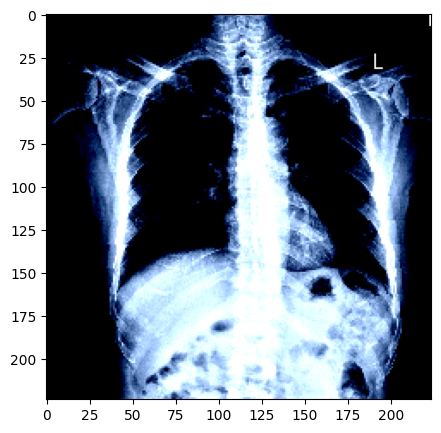

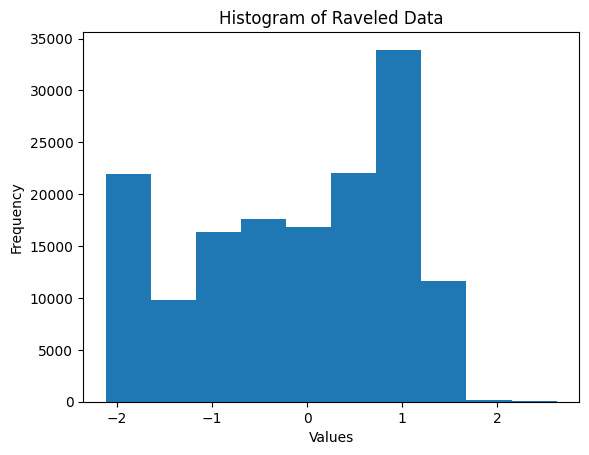

In [82]:
plt.figure(figsize=(5,5))
image = train_data[2]['image'].permute(1,2,0)
image.shape
plt.imshow(image)
plt.show()

plt.hist(image.ravel())
# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Raveled Data')
# Show the plot
plt.show()

In [83]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

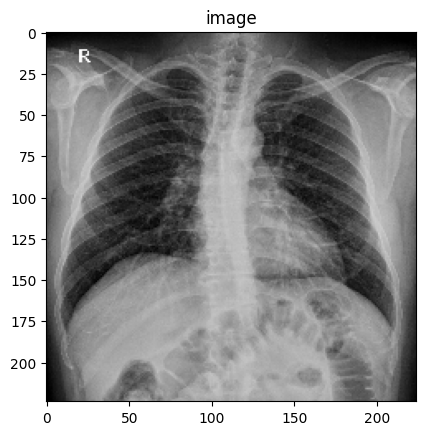

In [92]:
show_image(train_data[3]['image'], 'image')

In [93]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights)
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [100]:
summary(model=model,
       input_size=[1,3,224,224],
       col_names=['input_size', 'output_size', 'num_params','trainable'],
       col_width=17,
       row_settings=['var_names'])

Layer (type (var_name))                                           Input Shape       Output Shape      Param #           Trainable
MultiHeadmodel (MultiHeadmodel)                                   [1, 3, 224, 224]  [1, 1]            1,281,000         Partial
├─Sequential (model_wo_fc)                                        [1, 3, 224, 224]  [1, 1280, 1, 1]   --                False
│    └─Sequential (0)                                             [1, 3, 224, 224]  [1, 1280, 7, 7]   --                False
│    │    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]  [1, 32, 112, 112] (928)             False
│    │    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] (1,448)           False
│    │    └─Sequential (2)                                        [1, 16, 112, 112] [1, 24, 56, 56]   (16,714)          False
│    │    └─Sequential (3)                                        [1, 24, 56, 56]   [1, 40, 28, 28]   (46,640)  

In [95]:
for param in model.features.parameters():
     param.requires_grad = False
print('Freezing intermediate layer parameters...')

Freezing intermediate layer parameters...


In [96]:
class MultiHeadmodel(nn.Module):
    def __init__(self, model):
        super(MultiHeadmodel, self).__init__()
        self.model=model
        # change the final layers according to the number of categories
        self.model_wo_fc = nn.Sequential(*(list(self.model.children())[:-1]))
        self.EF40 = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=1),
            nn.Sigmoid()
           
        )
        self.TR0 = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=1),
            nn.Sigmoid()
        )
        self.MR0 = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=1),
            nn.Sigmoid()
            
        )
    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)
        l0 = self.EF40(x)
        l1 = self.TR0(x)
        l2 = self.MR0(x)
        return l0,l1,l2
       # return {'EF40':l0, 'TR0':l1, 'MR0':l2} 

In [97]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model

model = MultiHeadmodel(model=model)
# learning parameters
lr = 0.001
optimizer = optim.Adam(params=model.parameters(), lr=lr)
#criterion = loss_fn(outputs, targets)
batch_size = 5
epochs = 5

In [98]:
torch.manual_seed(42)
train_dataloader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(
    val_data, batch_size=1, shuffle=False
)

In [99]:
train_data[3]['image'].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [40]:
model

MultiHeadmodel(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_

In [101]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [102]:
def train(model, dataloader, optimizer, loss_fn, dataset, device):
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        
        # extract the features and labels
        image = data['image'].to(device)
        EF40 = data['EF40'].to(device).float()
        TR0 = data['TR0'].to(device).float()
        MR0 = data['MR0'].to(device).float()
        
        # zero-out the optimizer gradients
        optimizer.zero_grad()
        
        outputs = model(image)
        o1=outputs[0].view(-1)
        o2=outputs[1].view(-1)
        o3=outputs[2].view(-1)
        outputs=o1,o2,o3
        targets = (EF40, TR0, MR0)
        loss=loss_fn(outputs, targets)
        train_running_loss += loss.item()
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [103]:
def validate(model, dataloader, loss_fn, dataset, device):
    model.eval()
    counter = 0
    val_running_loss = 0.0
    df = pd.DataFrame({"proba_EF40":[],'proba_TR0':[],'proba_MR0':[],
                          'target_EF40':[],'target_TR0':[],'target_MR0':[]})
    with torch.inference_mode():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            
            # extract the features and labels
            image = data['image'].to(device)
            EF40 = data['EF40'].to(device).float()
            TR0 = data['TR0'].to(device).float()
            MR0 = data['MR0'].to(device).float()
            
            outputs = model(image)
            o1=outputs[0].view(-1)
            o2=outputs[1].view(-1)
            o3=outputs[2].view(-1)
            
            outputs=o1,o2,o3
            
            targets = (EF40, TR0, MR0)
            df = pd.concat([df, pd.DataFrame({"proba_EF40": o1.tolist(),
                                              "proba_TR0": o2.tolist(),
                                              "proba_MR0": o3.tolist(),
                                              'target_EF40':EF40.tolist(),
                                              'target_TR0':TR0.tolist(),
                                              'target_MR0':MR0.tolist(),
                                             })], axis=0, ignore_index=True)
    
            loss= loss_fn(outputs, targets)
            val_running_loss += loss.item()
            
    val_loss = val_running_loss / counter
    return val_loss, df

In [104]:
torch.manual_seed(42) 
train_loss, val_loss = [], []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_data, device
    )
    val_epoch_loss = validate(
        model, val_dataloader, loss_fn, val_data, device
    )
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Validation Loss: {val_epoch_loss[0]:.4f}")
# save the model to disk
save_model(model= model,
               target_dir= 'D:\AI2',
               model_name= 'Multilabel_echo_classifier.pth')

Epoch 1 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6514
Validation Loss: 0.6905
Epoch 2 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6090
Validation Loss: 0.6795
Epoch 3 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5569
Validation Loss: 0.6757
Epoch 4 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5298
Validation Loss: 0.6727
Epoch 5 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4991
Validation Loss: 0.6876
[INFO] Saving model to: D:\AI2\Multilabel_echo_classifier.pth


In [105]:
def binary(x):
    if x < 0.5:
        return 0
    else:
        return 1

# Apply the function to the original column and create a new column
val_epoch_loss[1]['predicted_EF40'] = val_epoch_loss[1]['proba_EF40'].apply(binary)
val_epoch_loss[1]['predicted_TR0'] = val_epoch_loss[1]['proba_TR0'].apply(binary)
val_epoch_loss[1]['predicted_MR0'] = val_epoch_loss[1]['proba_MR0'].apply(binary)

In [106]:
val_epoch_loss[1]

proba_EF40  proba_TR0  proba_MR0  target_EF40  target_TR0  target_MR0  \
0    0.107261   0.481750   0.698296          1.0         0.0         1.0   
1    0.151599   0.510679   0.548577          0.0         1.0         1.0   
2    0.175274   0.535544   0.597898          0.0         0.0         1.0   
3    0.159133   0.532648   0.603206          1.0         1.0         1.0   
4    0.187562   0.502922   0.637274          0.0         1.0         0.0   
5    0.182804   0.530314   0.607401          0.0         1.0         1.0   

   predicted_EF40  predicted_TR0  predicted_MR0  
0               0              0              1  
1               0              1              1  
2               0              1              1  
3               0              1              1  
4               0              1              1  
5               0              1              1

In [107]:
fpr1, tpr1, threshold1 = roc_curve(val_epoch_loss[1]['target_EF40'].values, val_epoch_loss[1]['proba_EF40'].values)
auc1 = round(metrics.roc_auc_score(val_epoch_loss[1]['target_EF40'].values, val_epoch_loss[1]['proba_EF40'].values), 4)

fpr2, tpr2, threshold2 = roc_curve(val_epoch_loss[1]['target_TR0'].values, val_epoch_loss[1]['proba_TR0'].values)
auc2 = round(metrics.roc_auc_score(val_epoch_loss[1]['target_TR0'].values, val_epoch_loss[1]['proba_TR0'].values), 4)

fpr3, tpr3, threshold3 = roc_curve(val_epoch_loss[1]['target_MR0'].values, val_epoch_loss[1]['proba_MR0'].values)
auc3 = round(metrics.roc_auc_score(val_epoch_loss[1]['target_MR0'].values, val_epoch_loss[1]['proba_MR0'].values), 4)

In [108]:
threshold2

array([1.53554428, 0.53554428, 0.50292182, 0.48175007])

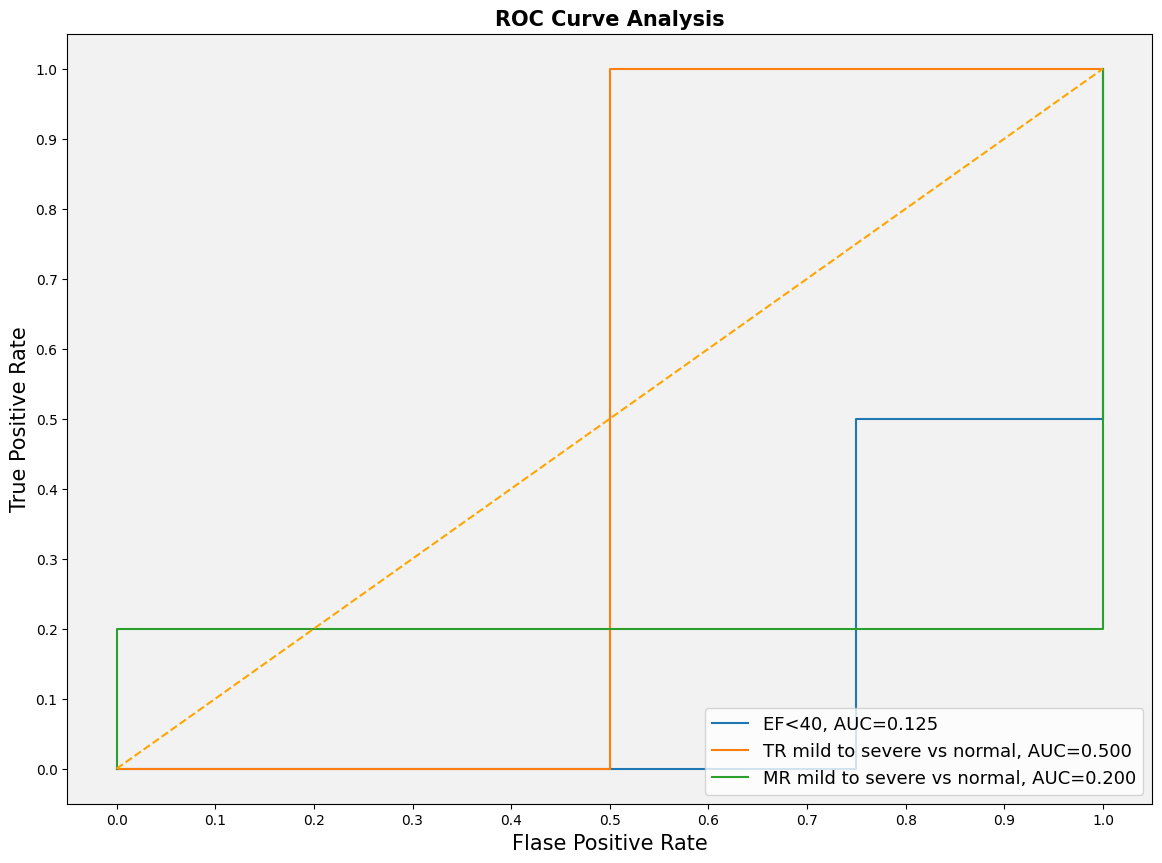

In [109]:
fig = plt.figure(figsize=(14,10))

ax = plt.axes()
ax.set_facecolor((0.95, 0.95, 0.95))

plt.plot(fpr1, 
             tpr1,
             label="EF<40, AUC={:.3f}".format(auc1))
plt.plot(fpr2, 
             tpr2,
             label="TR mild to severe vs normal, AUC={:.3f}".format(auc2))
plt.plot(fpr3, 
             tpr3,
             label="MR mild to severe vs normal, AUC={:.3f}".format(auc3))

# Setting the background color of the plot
# using set_facecolor() method

    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

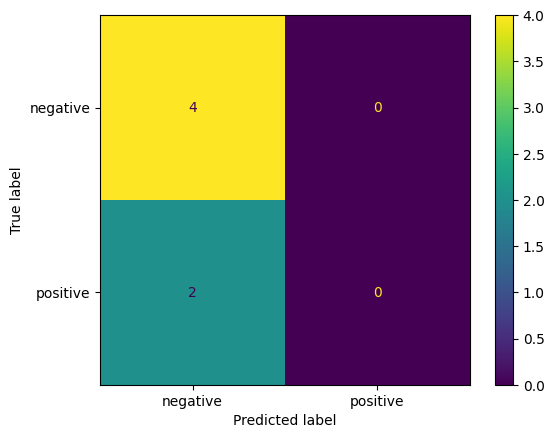

In [110]:
confusion_matrix = metrics.confusion_matrix(val_epoch_loss[1]['target_EF40'], val_epoch_loss[1]['predicted_EF40'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['negative', 'positive'])

cm_display.plot()
plt.show()

In [111]:
# Use this code to get the saved model size in megabytes
loaded_modelPath= Path('D:\AI2\Multilabel_echo_classifier.pth').stat().st_size/(1024*1024)
print(f'loaded model size is {round(loaded_modelPath,2)} megabytes')
# Count number of model parameters
total_params=sum(torch.numel(param) for param in model.parameters())
print(f'model parameter number size is {round(total_params,2)}')
# to inspect the params run the below hashtagged code
#list(model.parameters())

loaded model size is 20.54 megabytes
model parameter number size is 5292391


In [112]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to('cpu')

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
random.seed(42)
torch.manual_seed(42)
# pretrained_vit # uncomment for model output 

In [113]:
from torchvision.models.feature_extraction import create_feature_extractor

feature_extractor = create_feature_extractor(pretrained_vit, return_nodes=['getitem_5'])

img = torch.rand(1, 3, 224, 224)
print(feature_extractor(img)['getitem_5'].shape)

torch.Size([1, 768])


In [117]:
# Print a summary using torchinfo
summary(model=Vit_transfered, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=17,
         row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape       Output Shape      Param #           Trainable
MultiHeadVit (MultiHeadVit)                                       [32, 3, 224, 224] [32, 1]           769,000           Partial
├─VisionTransformer (feature_extractor)                           [32, 3, 224, 224] [32, 768]         768               False
│    └─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)         False
│    └─Module (encoder)                                           --                --                151,296           False
│    │    └─Dropout (dropout)                                     [32, 197, 768]    [32, 197, 768]    --                --
│    │    └─Module (layers)                                       --                --                (85,054,464)      False
│    │    └─LayerNorm (ln)                                        [32, 197, 768]    [32, 197, 768]    (1,536)      

In [115]:
torch.manual_seed(42)
class MultiHeadVit(nn.Module):
    def __init__(self, model):
        super().__init__()
        # change the final layers according to the number of categories
        self.model= model
        self.feature_extractor = create_feature_extractor(self.model, return_nodes=['getitem_5'])
        self.EF40 = nn.Sequential(
            nn.Linear(in_features=768, out_features=1),
            nn.Sigmoid() 
        )
        self.TR0 = nn.Sequential(
            nn.Linear(in_features=768, out_features=1),
            nn.Sigmoid()
        )
        self.MR0 = nn.Sequential(
            nn.Linear(in_features=768, out_features=1),
            nn.Sigmoid()   
        )
    def forward(self, x):
        x = self.feature_extractor(x)['getitem_5']
        #x = feature_extractor(x)['getitem_5']
        x = torch.flatten(x, 1)
        l0 = self.EF40(x)
        l1 = self.TR0(x)
        l2 = self.MR0(x)
        return l0,l1,l2
       # return {'EF40':l0, 'TR0':l1, 'MR0':l2} 

In [116]:
Vit_transfered=MultiHeadVit(pretrained_vit)

In [139]:
torch.manual_seed(42) 
train_loss, val_loss = [], []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        Vit_transfered, train_dataloader, optimizer, loss_fn, train_data, device
    )
    val_epoch_loss = validate(
        Vit_transfered, val_dataloader, loss_fn, val_data, device
    )
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Validation Loss: {val_epoch_loss[0]:.4f}")
# save the model to disk
save_model(model= model,
               target_dir= 'D:\AI2',
               model_name= 'Vit_transfered.pth')

Epoch 1 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.7170
Validation Loss: 0.7637
Epoch 2 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.7606
Validation Loss: 0.7637
Epoch 3 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.7433
Validation Loss: 0.7637
Epoch 4 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.7605
Validation Loss: 0.7637
Epoch 5 of 5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.7310
Validation Loss: 0.7637
[INFO] Saving model to: D:\AI2\Vit_transfered.pth


In [143]:
val_loss

[(0.7636719544728597,
     proba_EF40  proba_TR0  proba_MR0  target_EF40  target_TR0  target_MR0
  0    0.484152   0.392942   0.585981          1.0         0.0         1.0
  1    0.531004   0.364080   0.549666          0.0         1.0         1.0
  2    0.584136   0.321210   0.498198          0.0         0.0         1.0
  3    0.726566   0.354651   0.462257          1.0         1.0         1.0
  4    0.591678   0.384958   0.697283          0.0         1.0         0.0
  5    0.581913   0.354174   0.561827          0.0         1.0         1.0),
 (0.7636719544728597,
     proba_EF40  proba_TR0  proba_MR0  target_EF40  target_TR0  target_MR0
  0    0.484152   0.392942   0.585981          1.0         0.0         1.0
  1    0.531004   0.364080   0.549666          0.0         1.0         1.0
  2    0.584136   0.321210   0.498198          0.0         0.0         1.0
  3    0.726566   0.354651   0.462257          1.0         1.0         1.0
  4    0.591678   0.384958   0.697283          0.0    

In [126]:
Vit_transfered

MultiHeadVit(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): La

In [127]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [141]:
def binary(x):
    if x < 0.5:
        return 0
    else:
        return 1

# Apply the function to the original column and create a new column
val_epoch_loss[1]['predicted_EF40'] = val_epoch_loss[1]['proba_EF40'].apply(binary)
val_epoch_loss[1]['predicted_TR0'] = val_epoch_loss[1]['proba_TR0'].apply(binary)
val_epoch_loss[1]['predicted_MR0'] = val_epoch_loss[1]['proba_MR0'].apply(binary)

In [142]:
val_epoch_loss[1]

proba_EF40  proba_TR0  proba_MR0  target_EF40  target_TR0  target_MR0  \
0    0.484152   0.392942   0.585981          1.0         0.0         1.0   
1    0.531004   0.364080   0.549666          0.0         1.0         1.0   
2    0.584136   0.321210   0.498198          0.0         0.0         1.0   
3    0.726566   0.354651   0.462257          1.0         1.0         1.0   
4    0.591678   0.384958   0.697283          0.0         1.0         0.0   
5    0.581913   0.354174   0.561827          0.0         1.0         1.0   

   predicted_EF40  predicted_TR0  predicted_MR0  
0               0              0              1  
1               1              0              1  
2               1              0              0  
3               1              0              0  
4               1              0              1  
5               1              0              1

In [138]:
for name, param in Vit_transfered.named_parameters():
    print(name, param.grad)

model.class_token None
model.conv_proj.weight None
model.conv_proj.bias None
model.encoder.pos_embedding None
model.encoder.layers.encoder_layer_0.ln_1.weight None
model.encoder.layers.encoder_layer_0.ln_1.bias None
model.encoder.layers.encoder_layer_0.self_attention.in_proj_weight None
model.encoder.layers.encoder_layer_0.self_attention.in_proj_bias None
model.encoder.layers.encoder_layer_0.self_attention.out_proj.weight None
model.encoder.layers.encoder_layer_0.self_attention.out_proj.bias None
model.encoder.layers.encoder_layer_0.ln_2.weight None
model.encoder.layers.encoder_layer_0.ln_2.bias None
model.encoder.layers.encoder_layer_0.mlp.0.weight None
model.encoder.layers.encoder_layer_0.mlp.0.bias None
model.encoder.layers.encoder_layer_0.mlp.3.weight None
model.encoder.layers.encoder_layer_0.mlp.3.bias None
model.encoder.layers.encoder_layer_1.ln_1.weight None
model.encoder.layers.encoder_layer_1.ln_1.bias None
model.encoder.layers.encoder_layer_1.self_attention.in_proj_weight Non

In [140]:
for name, param in Vit_transfered.named_parameters():
    print(name, param.grad)

model.class_token None
model.conv_proj.weight None
model.conv_proj.bias None
model.encoder.pos_embedding None
model.encoder.layers.encoder_layer_0.ln_1.weight None
model.encoder.layers.encoder_layer_0.ln_1.bias None
model.encoder.layers.encoder_layer_0.self_attention.in_proj_weight None
model.encoder.layers.encoder_layer_0.self_attention.in_proj_bias None
model.encoder.layers.encoder_layer_0.self_attention.out_proj.weight None
model.encoder.layers.encoder_layer_0.self_attention.out_proj.bias None
model.encoder.layers.encoder_layer_0.ln_2.weight None
model.encoder.layers.encoder_layer_0.ln_2.bias None
model.encoder.layers.encoder_layer_0.mlp.0.weight None
model.encoder.layers.encoder_layer_0.mlp.0.bias None
model.encoder.layers.encoder_layer_0.mlp.3.weight None
model.encoder.layers.encoder_layer_0.mlp.3.bias None
model.encoder.layers.encoder_layer_1.ln_1.weight None
model.encoder.layers.encoder_layer_1.ln_1.bias None
model.encoder.layers.encoder_layer_1.self_attention.in_proj_weight Non